In [1]:
import numpy as np
import pandas as pd
import os 
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-notebook')

# Loading the data


Our first task involves uploading the matrix of data from the excel spreadsheet containing patient IDs and their information. A lot of these values are not evaluated, so we must remove all the NaNs. Since we have to remove patients that don't have a CDR score, which will be what we use to label patients as having Alzheimer's Disease (AD) or not (NC), we lose a lot of patients from our original set. We go from 416 to 216, losing 200 patients.

In [2]:
demographics = pd.read_excel('oasis_cross-sectional.xls', sheet_name=3) # load data
print("{} columns and {} rows".format(demographics.shape[1], demographics.shape[0]))
df = demographics.dropna(how='any') # remove NaN values
df.head()

11 columns and 416 rows


,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1343.75,0.743,1.30604
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1146.59,0.810,1.53063
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454.24,0.708,1.20682
8,OAS1_0010_MR1,M,R,74,5.0,2.0,30.0,0.0,1636.08,0.689,1.07269
9,OAS1_0011_MR1,F,R,52,3.0,2.0,30.0,0.0,1320.81,0.827,1.32873


# Abbreviations

### SES(Socio Economic Status)
Education codes correspond to the following levels of education: 
1: less than high school grad., 2: high school grad., 3: some college, 4: college grad., 5: beyond college.

### MMSE(Mini-Mental State Examination)
Exam conducted by the doctor where the Maximum Score is 30

### CDR(Clinical Dementia Rating)
0= nondemented; 0.5 – very mild dementia; 1 = mild dementia; 2 = moderate dementia

### eTIV(Estimated total intracranial volume)

### nWBV(Normalized whole brain volume)

### ASF(Atlas scaling factor)

All patients are right handed, and thusly is a variable we will ignore. The ASF is a unitless factor that will also be ignored. To get an idea of what each kind of patient looks like, we chose patient 58 and patient 308 as examples for AD and NC relatively. We will also ignore eTIV as it a normalized measurement that is unbiased by atrophy which is something we are concerned with.

In [3]:
print("{} Rows and {} Columns".format(df.shape[0], df.shape[1]))
df_columns = list(demographics.columns)
X_columns = np.delete(df_columns, [6,7], None) # X matrix won't have MMSE or CDR scores
Xdf = df.reindex(columns=X_columns)
X = Xdf.values # creating X
HealthyExampleIndex = 27
SickExampleIndex = 145
print(X_columns)
print(X[HealthyExampleIndex])
print(X[SickExampleIndex])

216 Rows and 11 Columns
['ID' 'M/F' 'Hand' 'Age' 'Educ' 'SES' 'eTIV' 'nWBV' 'ASF']
['OAS1_0058_MR1' 'F' 'R' 46 5.0 1.0 1584.7 0.817 1.10747]
['OAS1_0308_MR1' 'F' 'R' 78 3.0 3.0 1401.13 0.703 1.25256]


We see that patient 58 is female, right-handed (all patients are right handed), 46 years old, well educated (5 years of education), relatively well off (SES based on the Hollingshead Index is 1, and has a normalized whole brain volume of 0.817.
On the other hand, patient 308 is female, right-handed, 78 years old, not as well educated (3 years of education), not as well off (an Hollingshead Index of 3), and has a normalized whole brain volume of 0.703.

## Loading the Images

In [4]:
# Define function to get list of pngs based on slice number
pngs_path='OASIS_MR1_pngs'
def getcoronalPNG(path):
    l = []
    coronalslice90_files = []
    coronalslice91_files = []
    coronalslice92_files = []
    coronalslice93_files = []
    coronalslice94_files = []
    coronalslice95_files = []
    coronalslice96_files = []
    coronalslice97_files = []
    coronalslice98_files = []
    coronalslice99_files = []
    
    for root, directories, filenames in os.walk(path):
        
        for filename in filenames:
            if ".90." in filename: 
                coronalslice90_files.append(os.path.join(root, filename))
            if ".91." in filename: 
                coronalslice91_files.append(os.path.join(root, filename))
            if ".92." in filename: 
                coronalslice92_files.append(os.path.join(root, filename))
            if ".93." in filename: 
                coronalslice93_files.append(os.path.join(root, filename))
            if ".94." in filename: 
                coronalslice94_files.append(os.path.join(root, filename))
            if ".95." in filename: 
                coronalslice95_files.append(os.path.join(root, filename))
            if ".96." in filename: 
                coronalslice96_files.append(os.path.join(root, filename))
            if ".97." in filename: 
                coronalslice97_files.append(os.path.join(root, filename))
            if ".98." in filename: 
                coronalslice98_files.append(os.path.join(root, filename))
            if ".99." in filename: 
                coronalslice99_files.append(os.path.join(root, filename))

    l = list(zip(coronalslice90_files, coronalslice91_files, coronalslice92_files, coronalslice93_files, coronalslice94_files, coronalslice95_files, coronalslice96_files, coronalslice97_files, coronalslice98_files, coronalslice99_files))

    return ((np.asarray(l)))

coronal_files0 = getcoronalPNG(pngs_path)
print(coronal_files0)

[['OASIS_MR1_pngs\\OAS1_0001_MR1\\OAS1_0001_MR1.90.png'
  'OASIS_MR1_pngs\\OAS1_0001_MR1\\OAS1_0001_MR1.91.png'
  'OASIS_MR1_pngs\\OAS1_0001_MR1\\OAS1_0001_MR1.92.png' ...
  'OASIS_MR1_pngs\\OAS1_0001_MR1\\OAS1_0001_MR1.97.png'
  'OASIS_MR1_pngs\\OAS1_0001_MR1\\OAS1_0001_MR1.98.png'
  'OASIS_MR1_pngs\\OAS1_0001_MR1\\OAS1_0001_MR1.99.png']
 ['OASIS_MR1_pngs\\OAS1_0002_MR1\\OAS1_0002_MR1.90.png'
  'OASIS_MR1_pngs\\OAS1_0002_MR1\\OAS1_0002_MR1.91.png'
  'OASIS_MR1_pngs\\OAS1_0002_MR1\\OAS1_0002_MR1.92.png' ...
  'OASIS_MR1_pngs\\OAS1_0002_MR1\\OAS1_0002_MR1.97.png'
  'OASIS_MR1_pngs\\OAS1_0002_MR1\\OAS1_0002_MR1.98.png'
  'OASIS_MR1_pngs\\OAS1_0002_MR1\\OAS1_0002_MR1.99.png']
 ['OASIS_MR1_pngs\\OAS1_0003_MR1\\OAS1_0003_MR1.90.png'
  'OASIS_MR1_pngs\\OAS1_0003_MR1\\OAS1_0003_MR1.91.png'
  'OASIS_MR1_pngs\\OAS1_0003_MR1\\OAS1_0003_MR1.92.png' ...
  'OASIS_MR1_pngs\\OAS1_0003_MR1\\OAS1_0003_MR1.97.png'
  'OASIS_MR1_pngs\\OAS1_0003_MR1\\OAS1_0003_MR1.98.png'
  'OASIS_MR1_pngs\\OAS1_0003_MR1\\

In [5]:
coronal_X_files = np.take(coronal_files0, indices=df.index.values, axis=0) # keeps the images with the same index as X matrix
coronal90loc, coronal91loc, coronal92loc, coronal93loc, coronal94loc, coronal95loc, coronal96loc, coronal97loc, coronal98loc, coronal99loc = zip(*coronal_X_files)
#print(coronal90loc, coronal91loc, coronal92loc, coronal93loc, coronal94loc, coronal95loc, coronal96loc, coronal97loc, coronal98loc, coronal99loc)

## Cleaning up the X variables


We then need to change the X variables into interpretable simpler ones that the algorithm can understand. We encode males as 1, and females as -1. I also went ahead and encoded the hands, but one should realize that all the patients are right handed.

In [6]:
X_id, X_gender, X_handedness, X_age, X_education, X_SES, X_eTIV, X_nWBV, X_ASF = zip(*X) # unzips big X matrix

def gender_translator(X_gender):
    X_gender_binary = []
    X_gender_encoded = []
    for x in X_gender:
        if x == 'M':
            X_gender_binary.append(1)
            X_gender_encoded.append([0,1])
        else:
            X_gender_binary.append(-1)
            X_gender_encoded.append([1,0])
    
    return(zip(X_gender_binary, X_gender_encoded)) # gives us binary and one-hot encoded for sex
           
def hand_translator(X_handedness):
    X_hand_binary = []
    X_hand_encoded = []
    for x in X_handedness:
        if x == 'R':
            X_hand_binary.append(1)
            X_hand_encoded.append([0,1])
        else:
            X_hand_binary.append(-1)
            X_hand_encoded.append([1,0])
    
    return(zip(X_hand_binary, X_hand_encoded)) # same as above but for handedness

X_gender_binary, X_gender_encoded = zip(*gender_translator(X_gender)) # unzipping to get our function outputs
X_hand_binary, X_hand_encoded = zip(*hand_translator(X_handedness))

## Image Processing

This function handles a little of the preprocessing we do to our images, namely reading in the image from the file locations, making them grayscale, and then scaling them from 0 to 255 to 0 to 1.

In [7]:
import sklearn
from sklearn import cluster
def prepPNGimgs(array_of_image_paths):
    l = []
    for img_file in array_of_image_paths: # for each file in the list of images...
        img = cv2.imread("{}".format(img_file)) # read the image...
        img = np.array(img, dtype=np.float64) / 255
        w, h, d = original_shape = tuple(img.shape)
        assert d == 3
        image_array = np.reshape(img, (w * h, d))
        kmeans = sklearn.cluster.KMeans(n_clusters=2, random_state=0).fit(image_array)
        labels = kmeans.predict(image_array)
        
        def recreate_image(codebook, labels, w, h):
            """Recreate the (compressed) image from the code book & labels"""
            d = codebook.shape[1]
            image = np.zeros((w, h, d))
            label_idx = 0
            for i in range(w):
                for j in range(h):
                    image[i][j] = (codebook[labels[label_idx]])
                    label_idx += 1
            return image
    
        clustImg = recreate_image(kmeans.cluster_centers_, labels, w, h)
        
        l.append(clustImg)
    
    return(np.asarray(l))

## Cleaning up the Y variables

In [8]:
Y_CDR_columns = [column_name for column_name in df_columns if column_name == 'CDR']

Y_CDR_df = df.reindex(columns=Y_CDR_columns)
Y_CDR = Y_CDR_df.values

Y_MMSE_columns = [column_name for column_name in df_columns if column_name == 'MMSE']
Y_MMSE_df = df.reindex(columns=Y_MMSE_columns)
Y_MMSE = Y_MMSE_df.values

CDR_threshold_0 = 0 # threshold values by CDR scale
CDR_threshold_0point5 = 0.5
CDR_threshold_1 = 1

MMSE_threshold_24 = 24 # threshold values by MMSE scale
MMSE_threshold_18 = 18

def CDR_probable_AD_thresholder(Y_CDR, threshold_value):
    Y_CDR_binary = []
    Y_CDR_encoded = []
    for y in Y_CDR:
        if y > threshold_value:
            Y_CDR_binary.append(1)
            Y_CDR_encoded.append([0,1])
        else:
            Y_CDR_binary.append(-1)
            Y_CDR_encoded.append([1,0])

    return((zip(Y_CDR_binary, Y_CDR_encoded)))

def MMSE_probable_Dementia_thresholder(Y_MMSE, threshold_value):
    Y_MMSE_binary = []
    Y_MMSE_encoded = []
    for y in Y_MMSE:
        if y < threshold_value:
            Y_MMSE_binary.append(1)
            Y_MMSE_encoded.append([0,1])
        else:
            Y_MMSE_binary.append(-1)
            Y_MMSE_encoded.append([1,0])
        
    return(zip(Y_MMSE_binary, Y_MMSE_encoded))

Y_CDR_binary, Y_CDR_encoded = zip(*CDR_probable_AD_thresholder(Y_CDR, CDR_threshold_0))
Y_MMSE_binary, Y_MMSE_encoded = zip(*MMSE_probable_Dementia_thresholder(Y_MMSE, MMSE_threshold_24))
print("Patient 58: CDR: {} ; MMSE: {}".format(Y_CDR[HealthyExampleIndex],Y_MMSE[HealthyExampleIndex]))
print("Patient 308: CDR: {} ; MMSE: {}".format(Y_CDR[SickExampleIndex],Y_MMSE[SickExampleIndex]))

Patient 58: CDR: [0.] ; MMSE: [30.]
Patient 308: CDR: [2.] ; MMSE: [15.]


Continuing with the same examples as before, patient 58 has a CDR score of 0, which is healthy and essentially NC, and the max MMSE score of 30, also healthy. On the other hand, patient 308 has a CDR score of 2, which is the maximum score on the CDR scale, and has a MMSE score of 15, extremely unhealthy, and indicative of AD.

## Final Processing Step

In [9]:
# turning everything into numpy arrays

df_index = np.asarray(df.index.values)
X_id = np.asarray(X_id)
X_gender = np.asarray(X_gender)
X_gender_binary = np.asarray(X_gender_binary)
X_gender_encoded = np.asarray(X_gender_encoded)
X_handedness = np.asarray(X_handedness)
X_hand_binary = np.asarray(X_hand_binary)
X_hand_encoded = np.asarray(X_hand_encoded)
X_age = np.asarray(X_age) 
X_education = np.asarray(X_education) 
X_SES = np.asarray(X_SES)
X_eTIV = np.asarray(X_eTIV)
X_nWBV = np.asarray(X_nWBV)
X_ASF = np.asarray(X_ASF)
coronal90loc = np.asarray(coronal90loc) 
coronal91loc = np.asarray(coronal91loc)
coronal92loc = np.asarray(coronal92loc) 
coronal93loc = np.asarray(coronal93loc)
coronal94loc = np.asarray(coronal94loc)
coronal95loc = np.asarray(coronal95loc) 
coronal96loc = np.asarray(coronal96loc) 
coronal97loc = np.asarray(coronal97loc) 
coronal98loc = np.asarray(coronal98loc) 
coronal99loc = np.asarray(coronal99loc)
coronal90_tensor = prepPNGimgs(coronal90loc)
coronal91_tensor = prepPNGimgs(coronal91loc)
coronal92_tensor = prepPNGimgs(coronal92loc)
coronal93_tensor = prepPNGimgs(coronal93loc)
coronal94_tensor = prepPNGimgs(coronal94loc)
coronal95_tensor = prepPNGimgs(coronal95loc)
coronal96_tensor = prepPNGimgs(coronal96loc)
coronal97_tensor = prepPNGimgs(coronal97loc)
coronal98_tensor = prepPNGimgs(coronal98loc)
coronal99_tensor = prepPNGimgs(coronal99loc)
Y_CDR = np.squeeze(np.asarray(Y_CDR))
Y_CDR_binary = np.asarray(Y_CDR_binary)
Y_CDR_encoded = np.asarray(Y_CDR_encoded)
Y_MMSE = np.squeeze(np.asarray(Y_MMSE))
Y_MMSE_binary = np.asarray(Y_MMSE_binary)
Y_MMSE_encoded = np.asarray(Y_MMSE_encoded)

(array([ 9., 18., 51., 48., 42., 16., 16., 11.,  3.,  2.]),
 array([1122.77 , 1209.663, 1296.556, 1383.449, 1470.342, 1557.235,
        1644.128, 1731.021, 1817.914, 1904.807, 1991.7  ]),
 <a list of 10 Patch objects>)

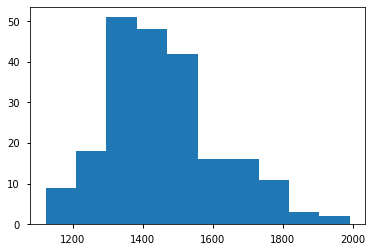

In [10]:
plt.hist(X_eTIV)

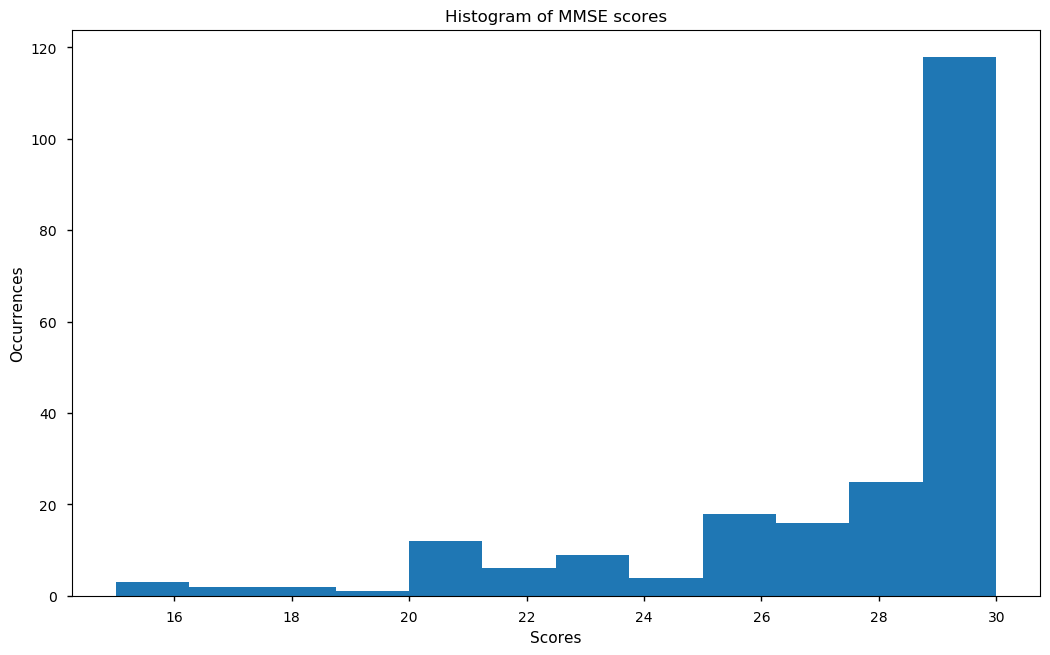

In [11]:
plt.figure(1, figsize=(12.5, 7.5), dpi=100)

hist = plt.hist(Y_MMSE, bins='auto')
plt.title('Histogram of MMSE scores')
plt.xlabel('Scores')
plt.ylabel('Occurrences')
plt.show()

# Analysis

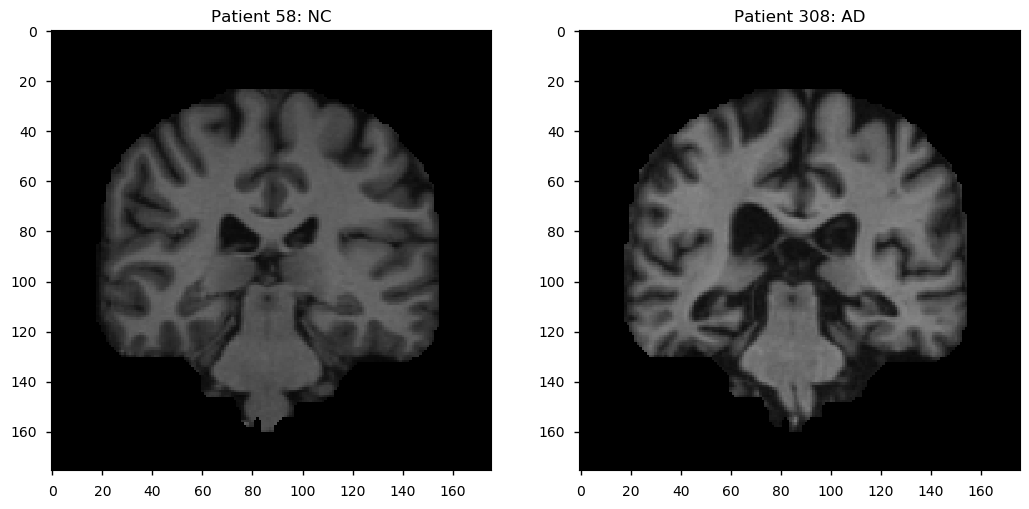

In [12]:
plt.figure(1, figsize=(12.5, 7.5), dpi=100)
plt.subplot(121)
plt.imshow(cv2.imread("{}".format(coronal90loc[HealthyExampleIndex])))
plt.title("Patient 58: NC")
plt.subplot(122)
plt.title("Patient 308: AD")
plt.imshow(cv2.imread("{}".format(coronal90loc[SickExampleIndex]))) 
plt.show()

Original scans of the example patients.

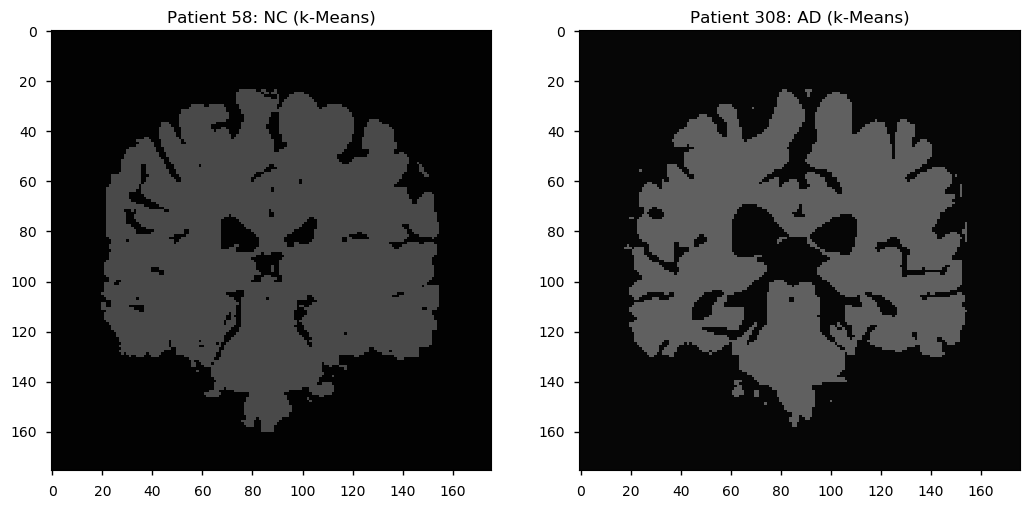

In [13]:

plt.figure(2, figsize=(12.5, 7.5), dpi=100)

plt.subplot(121)
plt.imshow(coronal90_tensor[HealthyExampleIndex])
plt.title("Patient 58: NC (k-Means)")

plt.subplot(122)
plt.imshow(coronal90_tensor[SickExampleIndex], cmap='spring')
plt.title("Patient 308: AD (k-Means)")

plt.show()

In [14]:
patient_holder = np.concatenate((coronal90_tensor,
                                 coronal91_tensor,
                                 coronal92_tensor,
                                 coronal93_tensor,
                                 coronal94_tensor,
                                 coronal95_tensor,
                                 coronal96_tensor,
                                 coronal97_tensor,
                                 coronal98_tensor,
                                 coronal99_tensor))
print(patient_holder.shape)

fin_Y_CDR_encoded = np.tile(Y_CDR_encoded, [10,1])

print(fin_Y_CDR_encoded.shape)

(2160, 176, 176, 3)
(2160, 2)


Scans after post processing.

In [15]:
train_percentage_as_decimal = 0.70
end = round(train_percentage_as_decimal*patient_holder.shape[0])
print(end)

X_train_tensor = patient_holder[0:end]
Y_train_output = fin_Y_CDR_encoded[0:end]
X_test_tensor = patient_holder[end:patient_holder.shape[0]]
Y_test_output = fin_Y_CDR_encoded[end:patient_holder.shape[0]]

print(Y_train_output.shape)
print("{}% of the training sample has No Condition".format((100*Y_train_output[:,0].sum()/Y_train_output.shape[0])))
print("{}% of the training sample has Alzheimer's Disease".format((100*Y_train_output[:,1].sum()/Y_train_output.shape[0])))
print(Y_test_output.shape)
print("{}% of the validation testing sample has No Condition".format((100*Y_test_output[:,0].sum()/Y_test_output.shape[0])))
print("{}% of the validation testing sample has Alzheimer's Disease".format((100*Y_test_output[:,1].sum()/Y_test_output.shape[0])))

1512
(1512, 2)
61.574074074074076% of the training sample has No Condition
38.425925925925924% of the training sample has Alzheimer's Disease
(648, 2)
61.574074074074076% of the validation testing sample has No Condition
38.425925925925924% of the validation testing sample has Alzheimer's Disease


In [16]:
import keras 
import tensorflow as tf
from keras import backend as K


print('Keras: ', keras.__version__, 'Tensorflow: ', tf.__version__)
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


Keras:  2.2.4 Tensorflow:  1.13.1


['/job:localhost/replica:0/task:0/device:GPU:0']

In [17]:
from keras import Sequential
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dropout, Dense

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(176,176,3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(1028, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1028, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
               optimizer='sgd',
               metrics=['categorical_accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 178, 178, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 176, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 178, 178, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 176, 176, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 88, 88, 64)        0         
_________________________________________________________________
zero_padding2d_3 (Zer

In [18]:
checkpoint_path="cp.ckpt"
checkpoint_dir=os.path.dirname(checkpoint_path)
cp_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_weights_only=True,verbose=1)

In [19]:
normhistory = model.fit(X_train_tensor, Y_train_output,
                        batch_size=32,
                        epochs=150,
                        verbose=1,
                        shuffle=True,
                        validation_data=(X_test_tensor, Y_test_output),
                        callbacks=[cp_callback])


score = model.evaluate(X_test_tensor, Y_test_output)

print('\nTest loss:', score[0])
print('\nTest accuracy:', score[1])

Instructions for updating:
Use tf.cast instead.
Train on 1512 samples, validate on 648 samples
Epoch 1/150
1512/1512 [==============================] - 40s 27ms/step - loss: 0.6836 - categorical_accuracy: 0.6118 - val_loss: 0.6751 - val_categorical_accuracy: 0.6157

Epoch 00001: saving model to cp.ckpt
Epoch 2/150
1512/1512 [==============================] - 21s 14ms/step - loss: 0.6720 - categorical_accuracy: 0.6157 - val_loss: 0.6689 - val_categorical_accuracy: 0.6157

Epoch 00002: saving model to cp.ckpt
Epoch 3/150
1512/1512 [==============================] - 21s 14ms/step - loss: 0.6683 - categorical_accuracy: 0.6157 - val_loss: 0.6667 - val_categorical_accuracy: 0.6157

Epoch 00003: saving model to cp.ckpt
Epoch 4/150
1512/1512 [==============================] - 21s 14ms/step - loss: 0.6670 - categorical_accuracy: 0.6157 - val_loss: 0.6663 - val_categorical_accuracy: 0.6157

Epoch 00004: saving model to cp.ckpt
Epoch 5/150
1512/1512 [==============================] - 21s 14ms/ste


Epoch 00038: saving model to cp.ckpt
Epoch 39/150
1512/1512 [==============================] - 21s 14ms/step - loss: 0.6660 - categorical_accuracy: 0.6157 - val_loss: 0.6657 - val_categorical_accuracy: 0.6157

Epoch 00039: saving model to cp.ckpt
Epoch 40/150
1512/1512 [==============================] - 21s 14ms/step - loss: 0.6659 - categorical_accuracy: 0.6157 - val_loss: 0.6657 - val_categorical_accuracy: 0.6157

Epoch 00040: saving model to cp.ckpt
Epoch 41/150
1512/1512 [==============================] - 21s 14ms/step - loss: 0.6663 - categorical_accuracy: 0.6157 - val_loss: 0.6658 - val_categorical_accuracy: 0.6157

Epoch 00041: saving model to cp.ckpt
Epoch 42/150
1512/1512 [==============================] - 21s 14ms/step - loss: 0.6661 - categorical_accuracy: 0.6157 - val_loss: 0.6657 - val_categorical_accuracy: 0.6157

Epoch 00042: saving model to cp.ckpt
Epoch 43/150
1512/1512 [==============================] - 21s 14ms/step - loss: 0.6663 - categorical_accuracy: 0.6157 - va

Epoch 78/150
1512/1512 [==============================] - 21s 14ms/step - loss: 0.6510 - categorical_accuracy: 0.6157 - val_loss: 0.6651 - val_categorical_accuracy: 0.6157

Epoch 00078: saving model to cp.ckpt
Epoch 79/150
1512/1512 [==============================] - 21s 14ms/step - loss: 0.6534 - categorical_accuracy: 0.6157 - val_loss: 0.6827 - val_categorical_accuracy: 0.6157

Epoch 00079: saving model to cp.ckpt
Epoch 80/150
1512/1512 [==============================] - 21s 14ms/step - loss: 0.6494 - categorical_accuracy: 0.6157 - val_loss: 0.6810 - val_categorical_accuracy: 0.6157

Epoch 00080: saving model to cp.ckpt
Epoch 81/150
1512/1512 [==============================] - 21s 14ms/step - loss: 0.6461 - categorical_accuracy: 0.6184 - val_loss: 0.6274 - val_categorical_accuracy: 0.6157

Epoch 00081: saving model to cp.ckpt
Epoch 82/150
1512/1512 [==============================] - 21s 14ms/step - loss: 0.6463 - categorical_accuracy: 0.6164 - val_loss: 0.6795 - val_categorical_accur

Epoch 117/150
1512/1512 [==============================] - 21s 14ms/step - loss: 0.3947 - categorical_accuracy: 0.8175 - val_loss: 0.4809 - val_categorical_accuracy: 0.7701

Epoch 00117: saving model to cp.ckpt
Epoch 118/150
1512/1512 [==============================] - 21s 14ms/step - loss: 0.3639 - categorical_accuracy: 0.8234 - val_loss: 0.4884 - val_categorical_accuracy: 0.7562

Epoch 00118: saving model to cp.ckpt
Epoch 119/150
1512/1512 [==============================] - 21s 14ms/step - loss: 0.3557 - categorical_accuracy: 0.8366 - val_loss: 0.5171 - val_categorical_accuracy: 0.7685

Epoch 00119: saving model to cp.ckpt
Epoch 120/150
1512/1512 [==============================] - 21s 14ms/step - loss: 0.3369 - categorical_accuracy: 0.8426 - val_loss: 0.6539 - val_categorical_accuracy: 0.7469

Epoch 00120: saving model to cp.ckpt
Epoch 121/150
1512/1512 [==============================] - 21s 14ms/step - loss: 0.3248 - categorical_accuracy: 0.8452 - val_loss: 0.4964 - val_categorical_

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy'])


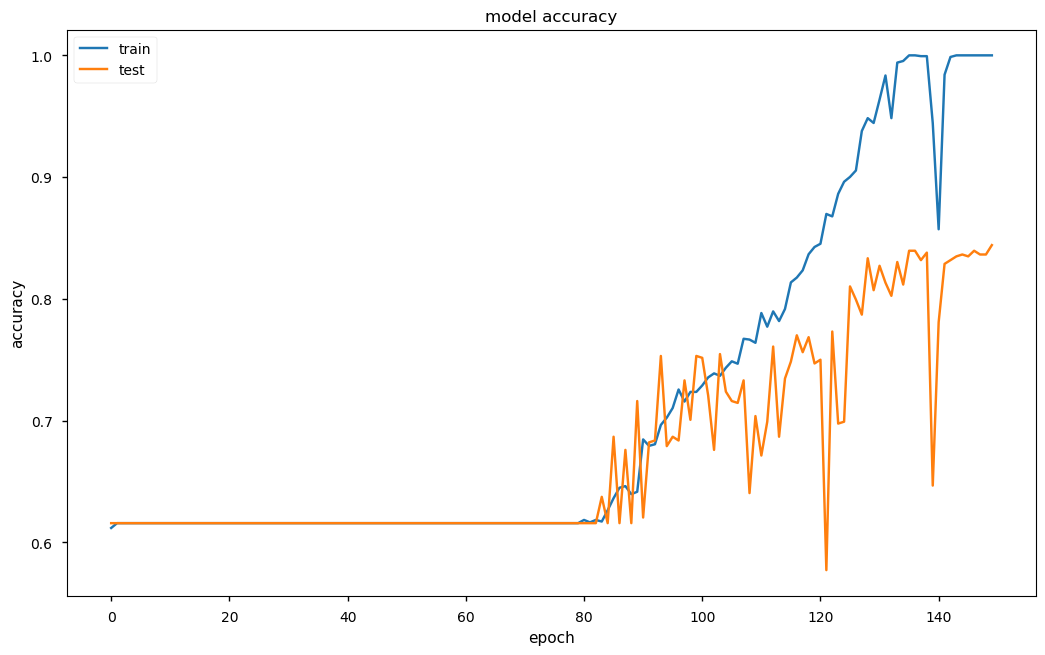

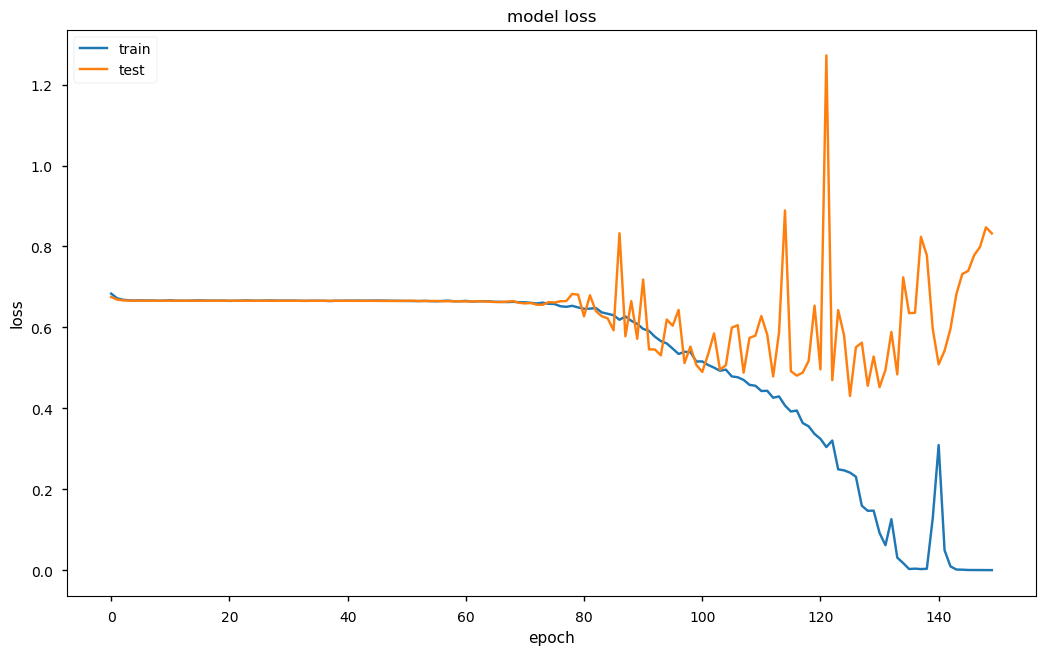

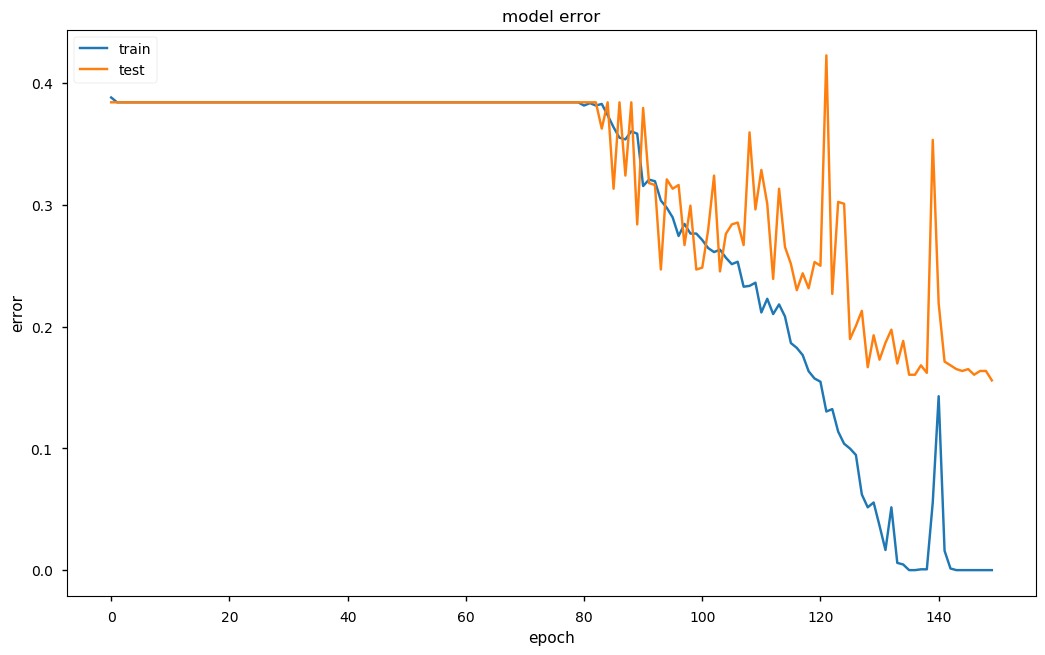

In [20]:
# list all data in history
print(normhistory.history.keys())
plt.figure(3, figsize=(12.5, 7.5), dpi=100)
# summarize history for accuracy
caterror = [1-x for x in normhistory.history['categorical_accuracy']]
valcaterror = [1-x for x in normhistory.history['val_categorical_accuracy']]
plt.plot(normhistory.history['categorical_accuracy'])
plt.plot(normhistory.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(3, figsize=(12.5, 7.5), dpi=100)
plt.plot(normhistory.history['loss'])
plt.plot(normhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.figure(3, figsize=(12.5, 7.5), dpi=100)
plt.plot(caterror)
plt.plot(valcaterror)
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
print(caterror.index(min(caterror)))
print(valcaterror.index(min(valcaterror)))
print(np.std(caterror))
print(np.mean(caterror))
print(np.std(valcaterror))
print(np.mean(valcaterror))

135
149
0.13619149968302421
0.287936507936508
0.08011994281281755
0.3263991769547325
